In [1]:
from ppxf.ppxf import ppxf
from ppxf import ppxf_util
from ppxf.ppxf_util import emission_lines
from ppxf.ppxf_util import log_rebin
from time import perf_counter as clock
from astropy.nddata import StdDevUncertainty


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from urllib.request import urlretrieve
import ppxf.sps_util as lib


### load data

In [2]:
#constants
redshift = 0.041185744
gain = 1.2 #e/ADU
readnoise = 5 #e

#slit width is 4.5

In [3]:
data = pd.read_csv('/Users/owner1/Documents/SURP/notebooks/SB/SB3_corrected_spectrum.csv')

In [4]:
#trim noisy regions
mask = np.where( (data['waveem'] > 4000) & (data['waveem'] < 7000))[0]
data = data.iloc[mask].reset_index(drop=True)

#normalize spectrum (suggested by ppxf)
data['flux'] = data['flux'] / np.median(data['flux'])

In [5]:
#resort into ascending order
data = data.sort_values('waveem', ascending=True).reset_index(drop=True)

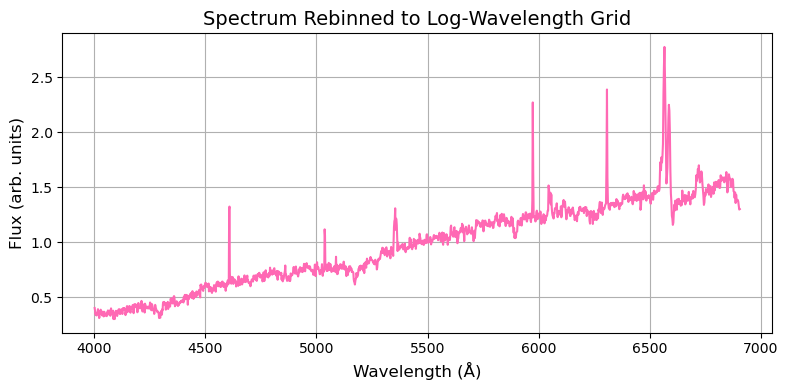

In [6]:
#rebin to log scale
flux_rebinned, ln_wave, velscale = log_rebin(data['waveem'], data['flux'])
lam = np.exp(ln_wave)


plt.figure(figsize=(8, 4))
plt.plot(lam, flux_rebinned, color='hotpink')
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Flux (arb. units)', fontsize=12)
plt.title('Spectrum Rebinned to Log‑Wavelength Grid', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Save in new pandas df
data = pd.DataFrame({'lam' : lam, 'ln_wave' : ln_wave, 'flux' : flux_rebinned})


# Normalize new spectrum
data['flux'] = data['flux'] / np.median(data['flux'])

In [8]:
# Add noise. From ppxf: "Constant noise is not a bad approximation and reduces overall nosie in the fit." They chose 0.01635. 
# But we approximate with std to account for worse data quality. Can play around with adding actual noise per pixel?
# Or maybe instead, if you have noise per pixel, take the median and use that instead. 

noise = np.full_like(data['flux'], np.std(data['flux']))
data['noise'] = noise

In [9]:
# #convert noise into log space 
# noise_rebinned = log_rebin(
#     [waveem[0], waveem[-1]],
#     noise,
#     velscale=velscale)[0] 

In [10]:
# Calculate velocity scale. log_rebin also does this, but can do it manually. Use the ln_lam to do this!!

c = 299792.458 # speed of light in km/s
d_ln_lam = (ln_wave[-1] - ln_wave[0])/(ln_wave.size - 1)  # Use full lam range for accuracy. Use ln_lam!
velscale = c * d_ln_lam    

In [11]:
velscale

101.27656599037681

In [12]:
R = 1092
fwhm = lam / R 

### define templates

In [13]:
lam_range_gal = np.array([np.min(lam), np.max(lam)])

In [14]:
lam_range_gal

array([4001.55184957, 6905.13404749])

In [15]:
sps_name = 'emiles'

ppxf_dir = Path(lib.__file__).parent

basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)


fwhm_gal_dic = {"lam": lam, "fwhm": fwhm}
sps = lib.sps_lib(filename, velscale, fwhm_gal_dic)

stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

In [16]:
stars_templates.shape

(10045, 150)

In [17]:
gas_templates, gas_names, gas_wave = \
    emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm_gal_dic)

# Filter for desired lines
mask = np.isin(gas_names, ["Halpha"])
gas_templates = gas_templates[:, mask]
gas_names = gas_names[mask]

#gas_templates = gas_templates[:stars_templates.shape[0]]

Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[SII]6716' '[SII]6731' 'HeII4687'
 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


In [18]:
gas_templates.shape

(10045, 1)

In [19]:
templates = np.hstack([stars_templates, gas_templates])

In [20]:
# How many stellar vs. gas templates?
n_stellar = stars_templates.shape[1]
n_gas     = gas_templates.shape[1]
print("Stellar templates:", n_stellar)
print("Gas templates:",     n_gas)

# See exactly which gas lines you got:
print("Gas names:", gas_names)


Stellar templates: 150
Gas templates: 1
Gas names: ['Halpha']


### fit

In [21]:
# Initial guesses

#vel0 = c*np.log(1 + redshift)
vel0 = 0
sol = [vel0, 200]

In [22]:
# add copmentents to each. All stellar templates shuold have the same compoment. All the balmer lines are connected too
# The rest are separate

#component = [0]*n_stellar       # all stellar
#component += [1]* 4      # Hδ, Hγ, Hβ, Hα
#component += [2] *2      # [S II]6716, [S II]6731
#component += [3, 4, 5, 6, 7] # He II4687, He I5876, [O III]5007, [O I]6300, [N II]6583


component = [0]*n_stellar  # Single stellar kinematic component=0 for all templates
component += [1]
#component += [2]
component = np.array(component)

In [23]:
# We're fitting two moments (i.e. velocity and sigma) for all 9 kinematic components
n_comp = component.max()+1
moments = [2]*n_comp

In [24]:
# Setup initial conditions
start = [sol for j in range(len(moments))]  # adopt the same starting value for both gas and stars

In [25]:
A_ineq = [[0, 0, 0, -1]]
   
b_ineq = [5]

constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}    


In [26]:
galaxy = data['flux'] 

 Best Fit:       Vel     sigma
 comp.  0:        90       277
 comp.  1:       121       217
chi2/DOF: 0.03896; DOF: 1602; degree = 1; mdegree = 10
method = capfit; Jac calls: 13; Func calls: 197; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/151
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Halpha      9.391       1.4     121   217
-----------------------------------------------------------------
Elapsed time in pPXF: 64.43


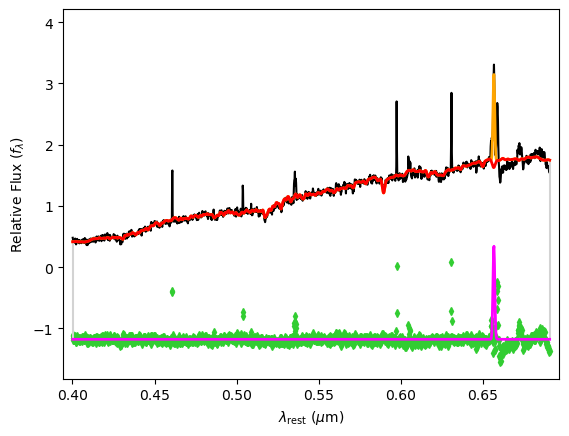

In [27]:
degree= 1
mdegree = 10
t = clock()
pp = ppxf(templates, galaxy, noise, velscale, start, plot=True,
            moments=moments, degree=degree, mdegree=mdegree, 
            lam=lam, component=component, 
            gas_component=component > 0, gas_names=gas_names,
            lam_temp=sps.lam_temp, constr_kinem = constr_kinem)

print(f"Elapsed time in pPXF: {(clock() - t):.2f}")

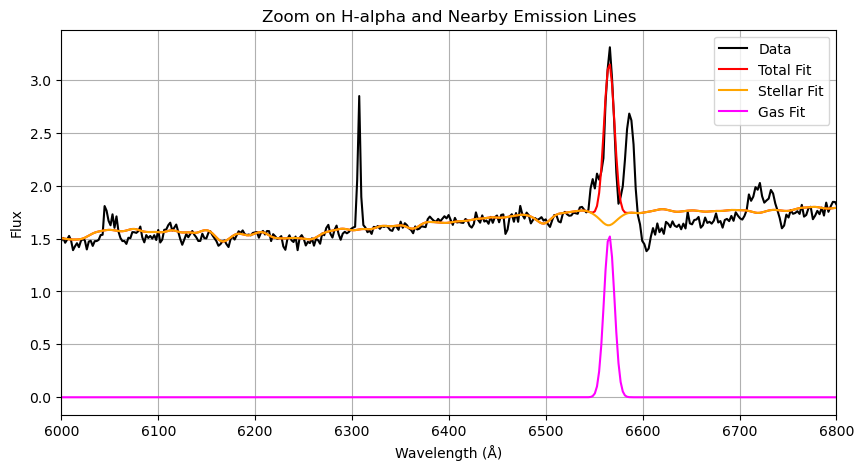

In [28]:
# Plot setup
plt.figure(figsize=(10, 5))
plt.plot(lam, galaxy, 'k', label='Data')
plt.plot(lam, pp.bestfit, 'r', label='Total Fit')
plt.plot(lam, pp.bestfit - pp.gas_bestfit, 'orange', label='Stellar Fit')
plt.plot(lam, pp.gas_bestfit, 'magenta', label='Gas Fit')


# Zoom in
plt.xlim(6000, 6800)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.legend()
plt.grid(True)
plt.title("Zoom on H-alpha and Nearby Emission Lines")
plt.show()
